# Demo 1: Predicting harmonic constants $n_h$ from LIGS time series

This notebook is a short demonstration of the LIGSNet classifier for the prediction of LIGS harmonic constants.\
The learning problem can be be framed as a simple binary classification problem, where the prediction of $n_h$ amounts to classifying the signal as thermal or electrostrictive.\
The model consists of a CNN pretrained in a convolutional autoencoder setting. The network was trained on a LIGS data set acquired in a high-pressure hydrogen-air gas turbine engine [(Chaib et al. 2024)](https://doi.org/10.1115/1.4065996) at the Gas Turbine Research Center (Cardiff, Wales, UK).\
The data set was augmented with random translations, through which the network was able to acquire translation invariance. Accuracies evaluated on translated and untranslated data are estimated at 90%.\
More details are provided in the associated paper(s).

## Loading packages

### Loading base packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
from sklearn.metrics import classification_report

if "CHDIR_EXECUTED" not in globals():
    os.chdir("..")
    CHDIR_EXECUTED = True

print("Current directory: " + os.getcwd())

Current directory: /Users/oussamachaib/Documents/GitHub/LIGSNet


### Loading custom packages

In [2]:
from loaders import load_preprocessed
from models.ConvClassifier import CNN

## Visualizing data

### Loading preprocessed LIGS data set

The preprocessed data set consists of:
* X : $n\times p$ matrix where rows correspond to individual observations (signals) and columns are features (voltage measurements per unit time)
* y : $n$ labels (one for each signal) depicting the dominant grating formation mechanism of each signal (0: thermal, 1: electrostrictive)

*Note*: The labels "y" are, in reality, pseudolabels obtained via the unsupervised framework "tulip", which can be found in the following repo: https://github.com/oussamachaib/tulips

In [3]:
X, y =  load_preprocessed()

### Plotting a signal

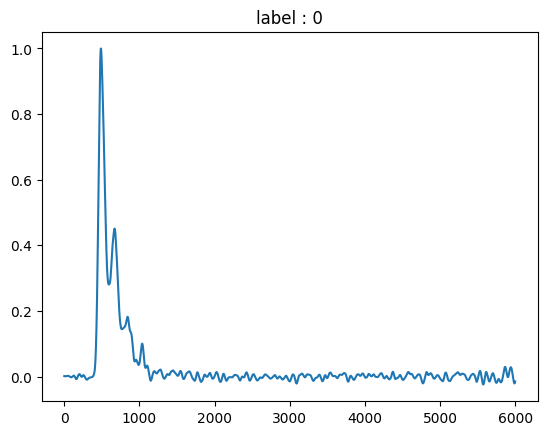

In [4]:
n = 24999
plt.figure()
plt.plot(X[n,:])
plt.title(f"label : {y[n]}")
plt.show()

## Loading pretrained CNN

Some clarifications:
1. The CNN is located in the "models" folder. It is sufficient to call the CNN class once to load the model.
2. Calling the "load_pretrained()" method will load the pretrained CNN. The latter was trained on the preprocessed data set augmented with random translations across the 1D canvas.

In [5]:
model = CNN()
model = model.load_pretrained()
model.to('cpu');

We can visualize the architecture of the network. It is a relatively standard CNN architecture with a convolutional backbone and a set of dense or fully-connected layers. The convolutional backbone is identical to that of the encoder, whose final parameters (i.e., after training) were used to initialize the CNN.\
Both the encoder and decoder attributes were kept in the "ConvClassifier" class for reference only.

In [6]:
model

CNN(
  (encoder): Sequential(
    (0): Conv1d(1, 12, kernel_size=(19,), stride=(3,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(12, 12, kernel_size=(19,), stride=(2,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(12, 24, kernel_size=(7,), stride=(2,))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(24, 24, kernel_size=(5,), stride=(2,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv1d(24, 48, kernel_size=(5,), stride=(2,))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv1d(48, 48, kernel_size=(5,), stride=(2,))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv1d(48, 48, kernel_size=(3,), stride=(2,))
    (13): LeakyReLU(negative_slope=0.01)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=1344, out_features=100, bias=True)
    (16): LeakyReLU(negative_slope=0.01)
    (17): Linear(in_features=100, out_features=50, bias=True)
    (18): LeakyReLU(negative_slope=0.01)
    (19): Linear(in_features=50, out_features=10,

## Inference

We can now start making predictions. A simple forward prop will output the content of the final neuron, which is a soft probability of electrostriction (between 0 and 1). The inference is a relatively light operation and it is sufficient to run it on the CPU.

Prior to that, some conversions should be made:
1. The data set has to be converted to a torch.float32 tensor.
2. The data set should be in the shape ($n$,1,$p$) where $n$ and $p$ refer to the number of observations (signals) and the number of features ($6000$ voltage measurements per unit time, by definition). The second dimension is the number of channels which is always going to be unity in the present setting.

In [7]:
S = X[n,:][np.newaxis, np.newaxis,:].astype(np.float32)
S.shape

(1, 1, 6000)

In [8]:
model.eval()
with torch.no_grad():
    pred = model.forward(torch.from_numpy(S))[0][0]

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [9]:
d = {'1': 'thermal', '2': 'electrostrictive'}
decision_level = 0.5
harmonic = int((pred>=decision_level)+1)
mechanism = d[f"{harmonic}"]

print(f'Signal {n} is '+ mechanism + f' (n_h = {harmonic}) | Probability: {abs((2 - harmonic) - pred)*100:3.2f}%')

Signal 24999 is thermal (n_h = 1) | Probability: 96.07%


We can also try running the model on the full data set and compare its output to our labels.

In [10]:
S = X.astype(np.float32)

with torch.no_grad():
    pred = model.forward(torch.from_numpy(S).unsqueeze(1))

harmonic = np.array(pred[:,0].numpy()>=0.5).astype(int)

In [11]:
print(classification_report(y, harmonic))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     11512
           1       0.85      0.98      0.91     13488

    accuracy                           0.90     25000
   macro avg       0.91      0.89      0.89     25000
weighted avg       0.91      0.90      0.90     25000



As can be seen, the model does an excellent job at predicting correct classes.\
Note the original CNN was trained on a different data set, which consists of LIGS signatures augmented with random translations.\
Thus, its excellent performance on the present unseen set of untranslated signals demonstrates its ability to make translation-invariant predictions.